91
50
Epoch 0 - Training loss: 2.242886543273926
Epoch 0 - Test loss: 2.1290714740753174
Epoch 1 - Training loss: 1.9622814655303955
Epoch 1 - Test loss: 1.6827300786972046
Epoch 2 - Training loss: 1.5705748796463013
Epoch 2 - Test loss: 1.3795825242996216
Epoch 3 - Training loss: 1.3472894430160522
Epoch 3 - Test loss: 1.2139785289764404
Epoch 4 - Training loss: 1.2178845405578613
Epoch 4 - Test loss: 1.1144601106643677
Epoch 5 - Training loss: 1.1347661018371582
Epoch 5 - Test loss: 1.0490171909332275
Epoch 6 - Training loss: 1.07652747631073
Epoch 6 - Test loss: 1.0017120838165283
Epoch 7 - Training loss: 1.031968116760254
Epoch 7 - Test loss: 0.9645965695381165
Epoch 8 - Training loss: 0.9964850544929504
Epoch 8 - Test loss: 0.9338617920875549
Epoch 9 - Training loss: 1.718532919883728
Epoch 9 - Test loss: 1.6940944194793701
Epoch 10 - Training loss: 1.2508114576339722
Epoch 10 - Test loss: 1.5313855409622192
Epoch 11 - Training loss: 1.1044944524765015
Epoch 11 - Test loss: 1.4604

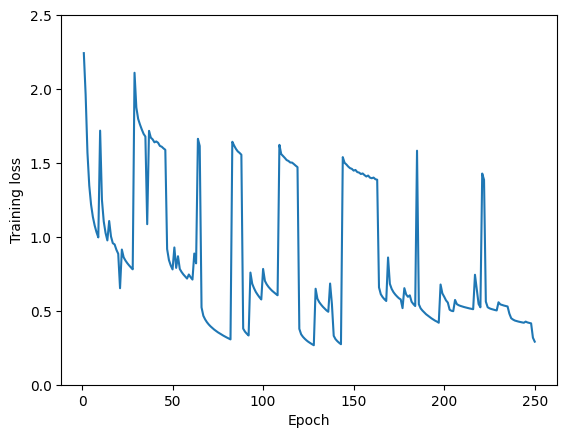

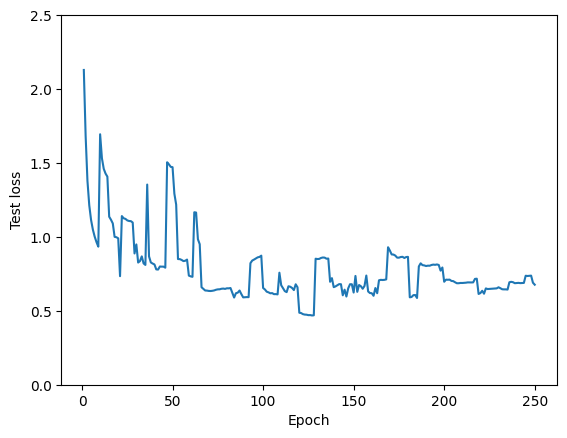

In [4]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 250
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
splitNN.group_testing(GROUP_TESTING_ROUNDS)

test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    sel = {}
    for own in splitNN.selected:
        sel[own] = splitNN.selected[own]
        splitNN.selected[own] = True
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    for own in splitNN.selected:
        splitNN.selected[own] = sel[own]
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



93
50
Epoch 0 - Training loss: 2.1562559604644775
Epoch 0 - Test loss: 1.8824349641799927
Epoch 1 - Training loss: 1.4975621700286865
Epoch 1 - Test loss: 1.191206455230713
Epoch 2 - Training loss: 1.0113887786865234
Epoch 2 - Test loss: 0.8707443475723267
Epoch 3 - Training loss: 0.8113957047462463
Epoch 3 - Test loss: 0.7384105920791626
Epoch 4 - Training loss: 0.7093835473060608
Epoch 4 - Test loss: 0.6732804775238037
Epoch 5 - Training loss: 0.6464818716049194
Epoch 5 - Test loss: 0.6341396570205688
Epoch 6 - Training loss: 0.6027041077613831
Epoch 6 - Test loss: 0.6071502566337585
Epoch 7 - Training loss: 0.5700193643569946
Epoch 7 - Test loss: 0.5853419303894043
Epoch 8 - Training loss: 0.5436256527900696
Epoch 8 - Test loss: 0.567826509475708
Epoch 9 - Training loss: 0.5225828886032104
Epoch 9 - Test loss: 0.5532523989677429
Epoch 10 - Training loss: 0.5050889849662781
Epoch 10 - Test loss: 0.5405658483505249
Epoch 11 - Training loss: 1.1237517595291138
Epoch 11 - Test loss: 0.9

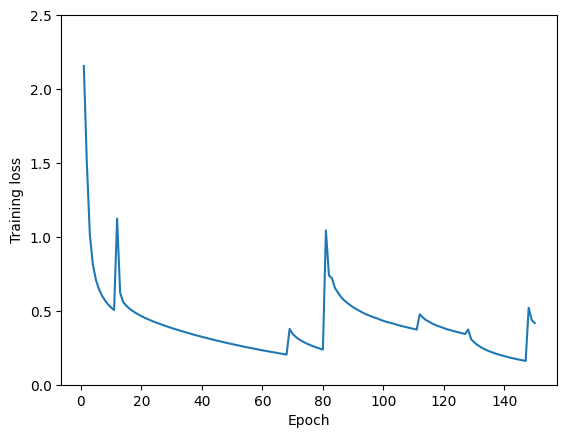

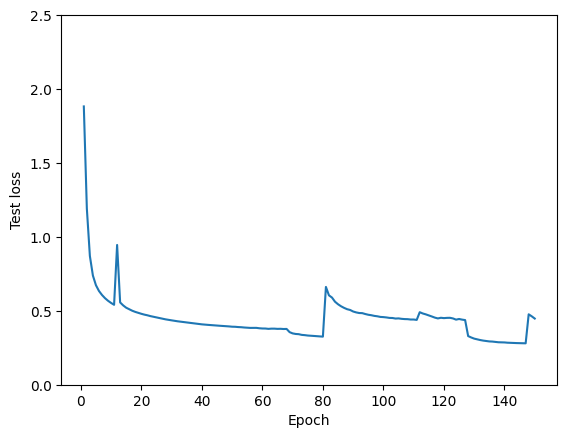

In [2]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 250
SUBSET_UPDATE_PROB = 0.05
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=3, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
splitNN.group_testing(GROUP_TESTING_ROUNDS)

test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



91
50
Epoch 0 - Training loss: 2.247748613357544
Epoch 0 - Test loss: 2.138552188873291
Epoch 1 - Training loss: 1.91609787940979
Epoch 1 - Test loss: 1.618330478668213
Epoch 2 - Training loss: 1.3591736555099487
Epoch 2 - Test loss: 1.117802381515503
Epoch 3 - Training loss: 1.3552453517913818
Epoch 3 - Test loss: 1.3279908895492554
Epoch 4 - Training loss: 1.202944040298462
Epoch 4 - Test loss: 1.0950106382369995
Epoch 5 - Training loss: 1.0666224956512451
Epoch 5 - Test loss: 0.9993945360183716
Epoch 6 - Training loss: 0.8245508670806885
Epoch 6 - Test loss: 0.7736371755599976
Epoch 7 - Training loss: 1.0116089582443237
Epoch 7 - Test loss: 0.8838599920272827
Epoch 8 - Training loss: 0.9301645755767822
Epoch 8 - Test loss: 0.831134557723999
Epoch 9 - Training loss: 0.8842636942863464
Epoch 9 - Test loss: 0.8021144866943359
Epoch 10 - Training loss: 0.706531286239624
Epoch 10 - Test loss: 0.6551482677459717
Epoch 11 - Training loss: 0.6345551609992981
Epoch 11 - Test loss: 0.61027276

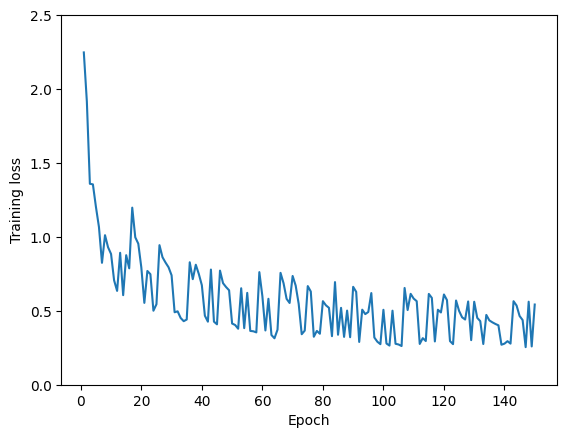

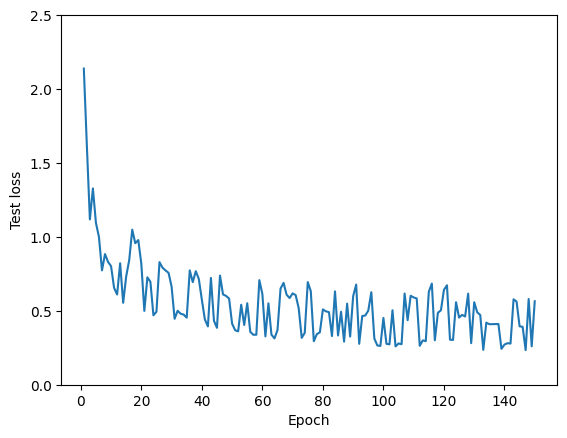

In [3]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 250
SUBSET_UPDATE_PROB = 0.8
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=3, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
splitNN.group_testing(GROUP_TESTING_ROUNDS)

test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()


    